# Columns Infos.

* **Id** - an Id that represents a (Store, Date) duple within the test set
* **Store** - a unique Id for each store
* **Sales** - the turnover for any given day (this is what you are predicting)
* **Customers** - the number of customers on a given day
* **Open** - an indicator for whether the store was open: 0 = closed, 1 = open
* **StateHoliday** - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
* **SchoolHoliday** - indicates if the (Store, Date) was affected by the closure of public schools
* **StoreType** - differentiates between 4 different store models: a, b, c, d
* **Assortment** - describes an assortment level: a = basic, b = extra, c = extended
* **CompetitionDistance** - distance in meters to the nearest competitor store
* **CompetitionOpenSince[Month/Year]** - gives the approximate year and month of the time the nearest competitor was opened
* **Promo** - indicates whether a store is running a promo on that day
* **Promo2** - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
* **Promo2Since[Year/Week]** - describes the year and calendar week when the store started participating in Promo2
* **PromoInterval** - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store.

# Imports

In [136]:
import pandas as pd
import inflection
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import math

from IPython.core.display import HTML
from IPython.display import Image
from scipy import stats as ss


pd.options.display.float_format = '{:,.6f}'.format
plt.rcParams['figure.figsize'] = [16, 10]



## Helper Functions

In [165]:
def cramer_v(x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k - 1) * (r - 1) / (n - 1))
    kcorr = k - (k - 1)**2 / (n - 1)
    rcorr = r - (r - 1)**2 / (n - 1)
    
    return np.sqrt((chi2corr / n) / (min(kcorr - 1, rcorr - 1)))

def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [16, 10]
    plt.rcParams['font.size'] = 18
    
    dusplay(HTML('<style>.container {width:100% !important;}</style'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    
    sns.set()

## Loading Data

In [2]:
df_sales_raw = pd.read_csv('C:\\Users\\felip\\repos\\data_science_em_producao\\rossmann_data\\train.csv', low_memory = False)
df_store_raw = pd.read_csv('C:\\Users\\felip\\repos\\data_science_em_producao\\rossmann_data\\store.csv', low_memory = False)

### [Merge - join two DataFrames.](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.merge.html)

In [3]:
df_raw = pd.merge(df_sales_raw, df_store_raw, how = 'left', on = 'Store')

# Data Description

## Rename Columns

In [4]:
# Dataset copy
df1 = df_raw.copy()

In [5]:
cols_old = list(df1.columns)

In [6]:
df1

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1017205,1112,2,2013-01-01,0,0,0,0,a,1,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1017206,1113,2,2013-01-01,0,0,0,0,a,1,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1017207,1114,2,2013-01-01,0,0,0,0,a,1,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


In [7]:
# Transforming columns names from CamelCase to SnakeCase.

snakecase = lambda x: inflection.underscore(x)

cols_new = list(map(snakecase, cols_old))

# Rename columns
df1.columns = cols_new

In [8]:
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## Data Dimensions

In [9]:
print(f'Number of Rows: {df1.shape[0]}.\nNumber of Columns: {df1.shape[1]}.')

Number of Rows: 1017209.
Number of Columns: 18.


## Data Types

In [10]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [11]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## Check NaN

In [12]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## Fillout NaN

The first method used, marked as a comment, was the method used by the instructor,
however, the "fillna ()" method is more efficient.

In [13]:
# competition_distance
    # I've assumed that the missing values on "competition_distance" column means that there are no competition 
    # near by the store, so I put a huge aleatory distance (bigger then oririnal max distance). 
    
# df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000 if math.isna(x) else x)

df1['competition_distance'].fillna(200000, inplace = True)

# competition_open_since_month

# df1['competition_open_since_month'] = df1['competition_open_since_month'].apply(lambda x: x['date].month 
    # if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'])
    
df1['competition_open_since_month'].fillna(df1['date'].dt.month, inplace = True)

#competition_open_since_year  

# df1['competition_open_since_year'] = df1['competition_open_since_year'].apply(lambda x: x['date].year 
    # if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'])
    
df1['competition_open_since_year'].fillna(df1['date'].dt.year, inplace = True)

#promo2_since_week   

#df1['promo2_since_week'] = df1['promo2_since_week'].apply(lambda x: x['date].week 
    # if math.isnan(x['promo2_since_week']) else x['promo2_since_week'])

df1['promo2_since_week'].fillna(df1['date'].dt.week, inplace = True)

#promo2_since_year     

#df1['promo2_since_year'] = df1['promo2_since_year'].apply(lambda x: x['date].year 
    # if math.isnan(x['promo2_since_year']) else x['promo2_since_year'])

df1['promo2_since_year'].fillna(df1['date'].dt.year, inplace = True)

#promo_interval

month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
             7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0, inplace = True)

df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis = 1)

<ipython-input-13-5c31fe8cabec>:28: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df1['promo2_since_week'].fillna(df1['date'].dt.week, inplace = True)


## Change Types

In [14]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('int64')
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype('int64')
df1['promo2_since_week'] = df1['promo2_since_week'].astype('int64')
df1['promo2_since_year'] = df1['promo2_since_year'].astype('int64')

## Descriptive Statistical

In [15]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## Numerical Attributes

In [16]:
df1.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
store,1017209.0,558.43,321.91,1.0,280.0,558.0,838.0,1115.0
day_of_week,1017209.0,4.00,2.00,1.0,2.0,4.0,6.0,7.0
sales,1017209.0,5773.82,3849.93,0.0,3727.0,5744.0,7856.0,41551.0
customers,1017209.0,633.15,464.41,0.0,405.0,609.0,837.0,7388.0
open,1017209.0,0.83,0.38,0.0,1.0,1.0,1.0,1.0
promo,1017209.0,0.38,0.49,0.0,0.0,0.0,1.0,1.0
school_holiday,1017209.0,0.18,0.38,0.0,0.0,0.0,0.0,1.0
competition_distance,1017209.0,5935.44,12547.65,20.0,710.0,2330.0,6910.0,200000.0
competition_open_since_month,1017209.0,6.79,3.31,1.0,4.0,7.0,10.0,12.0
competition_open_since_year,1017209.0,2010.32,5.52,1900.0,2008.0,2012.0,2014.0,2015.0


[Skewness and Kurtosis definitions](https://codeburst.io/2-important-statistics-terms-you-need-to-know-in-data-science-skewness-and-kurtosis-388fef94eeaa)

**Skewness - degree of distortion**

        * -0.5 and 0.5, the data are fairly symmetrical.
        * -1 and -0.5(negatively skewed) or between 0.5 and 1(positively skewed), the data are moderately skewed.
        * less than -1(negatively skewed) or greater than 1(positively skewed), the data are highly skewed.
        
**Kurtosis - measure of outliers**

        * >3 means that data are heavy-tailed or profusion of outliers.
        * <3 means that data are light-tailed or lack of outliers.
        * =3 means that the extreme values of the distribution are similar to that of a normal distribution characteristic.

In [17]:
num_attributes = df1.select_dtypes(include = ['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude = ['int64', 'float64', 'datetime64[ns]'])

In [18]:
display(num_attributes.describe().T)
display(cat_attributes.describe().T)

,count,mean,std,min,25%,50%,75%,max
store,1017209.0,558.429727,321.908651,1.0,280.0,558.0,838.0,1115.0
day_of_week,1017209.0,3.998341,1.997391,1.0,2.0,4.0,6.0,7.0
sales,1017209.0,5773.818972,3849.926175,0.0,3727.0,5744.0,7856.0,41551.0
customers,1017209.0,633.145946,464.411734,0.0,405.0,609.0,837.0,7388.0
open,1017209.0,0.830107,0.375539,0.0,1.0,1.0,1.0,1.0
promo,1017209.0,0.381515,0.485759,0.0,0.0,0.0,1.0,1.0
school_holiday,1017209.0,0.178647,0.383056,0.0,0.0,0.0,0.0,1.0
competition_distance,1017209.0,5935.442677,12547.652996,20.0,710.0,2330.0,6910.0,200000.0
competition_open_since_month,1017209.0,6.786849,3.311087,1.0,4.0,7.0,10.0,12.0
competition_open_since_year,1017209.0,2010.324840,5.515593,1900.0,2008.0,2012.0,2014.0,2015.0


,count,unique,top,freq
state_holiday,1017209,4,0,986159
store_type,1017209,4,a,551627
assortment,1017209,3,a,537445
promo_interval,1017209,4,0,508031
month_map,1017209,12,May,103695


In [19]:
# Central Tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

In [20]:
# Concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


C:\Users\felip\Anaconda3\envs\DataScienceEmProducao\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


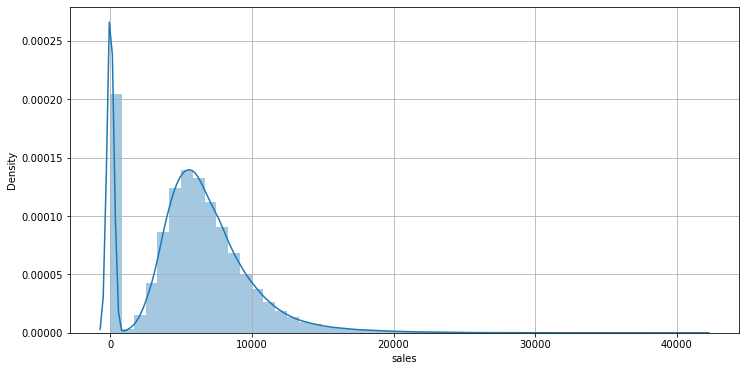

In [21]:
plt.figure(figsize = (12, 6))
sns.distplot(df1['sales'])
plt.grid()

C:\Users\felip\Anaconda3\envs\DataScienceEmProducao\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='competition_distance', ylabel='Density'>

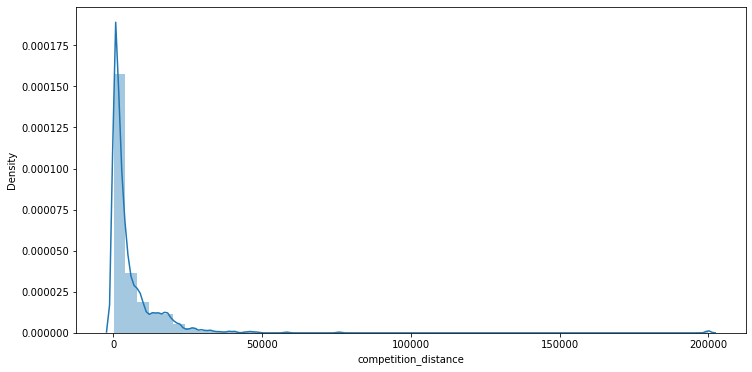

In [22]:
plt.figure(figsize = (12, 6))
sns.distplot(df1['competition_distance'])

## Categorical Attributes

In [23]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='state_holiday', ylabel='sales'>

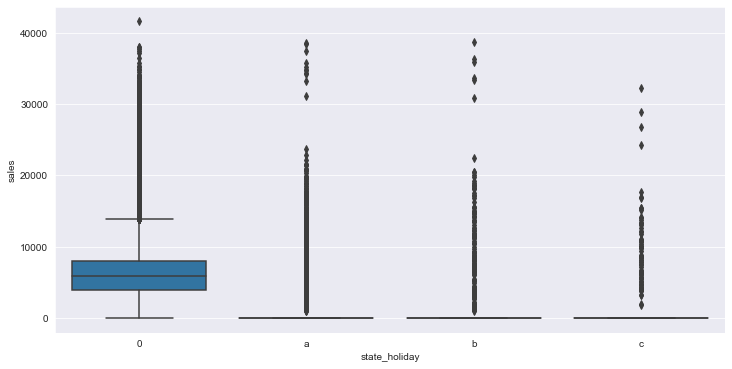

In [24]:
plt.figure(figsize = (12, 6))
sns.set_style("darkgrid")
sns.boxplot(x = 'state_holiday', y = 'sales', data = df1)

<AxesSubplot:xlabel='state_holiday', ylabel='sales'>

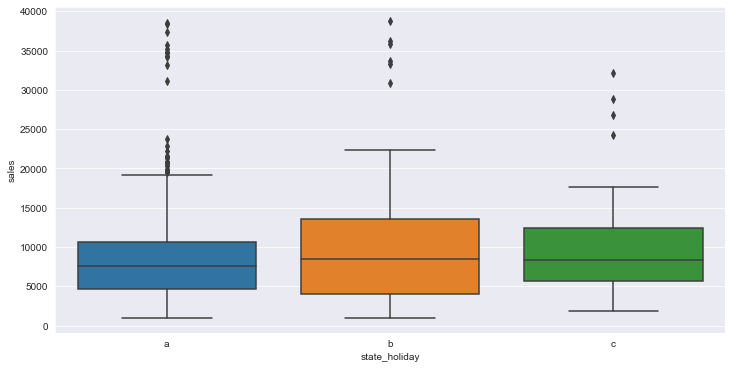

In [25]:
aux1 = df1[(df1['state_holiday'] != "0") & (df1['sales'] > 0)]
plt.figure(figsize = (12, 6))
sns.set_style("darkgrid")
sns.boxplot(x = 'state_holiday', y = 'sales', data = aux1)

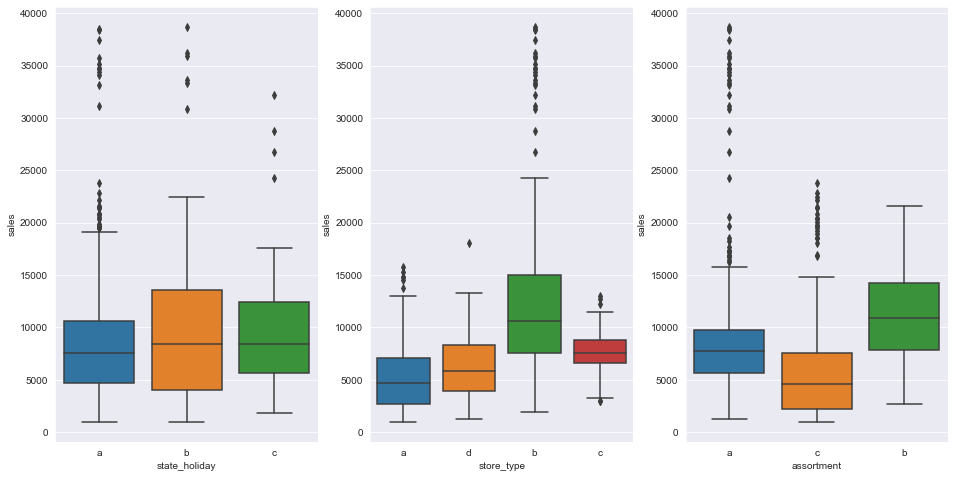

In [26]:
plt.figure(figsize = (16, 8))

plt.subplot(1, 3, 1)
sns.boxplot(x = 'state_holiday', y = 'sales', data = aux1)

plt.subplot(1, 3, 2)
sns.boxplot(x = 'store_type', y = 'sales', data = aux1)

plt.subplot(1, 3, 3)
sns.boxplot(x = 'assortment', y = 'sales', data = aux1)

plt.show()

# Feature Enginnering

**uploading hypothesis mind map**

[coggle](https://coggle.it/)

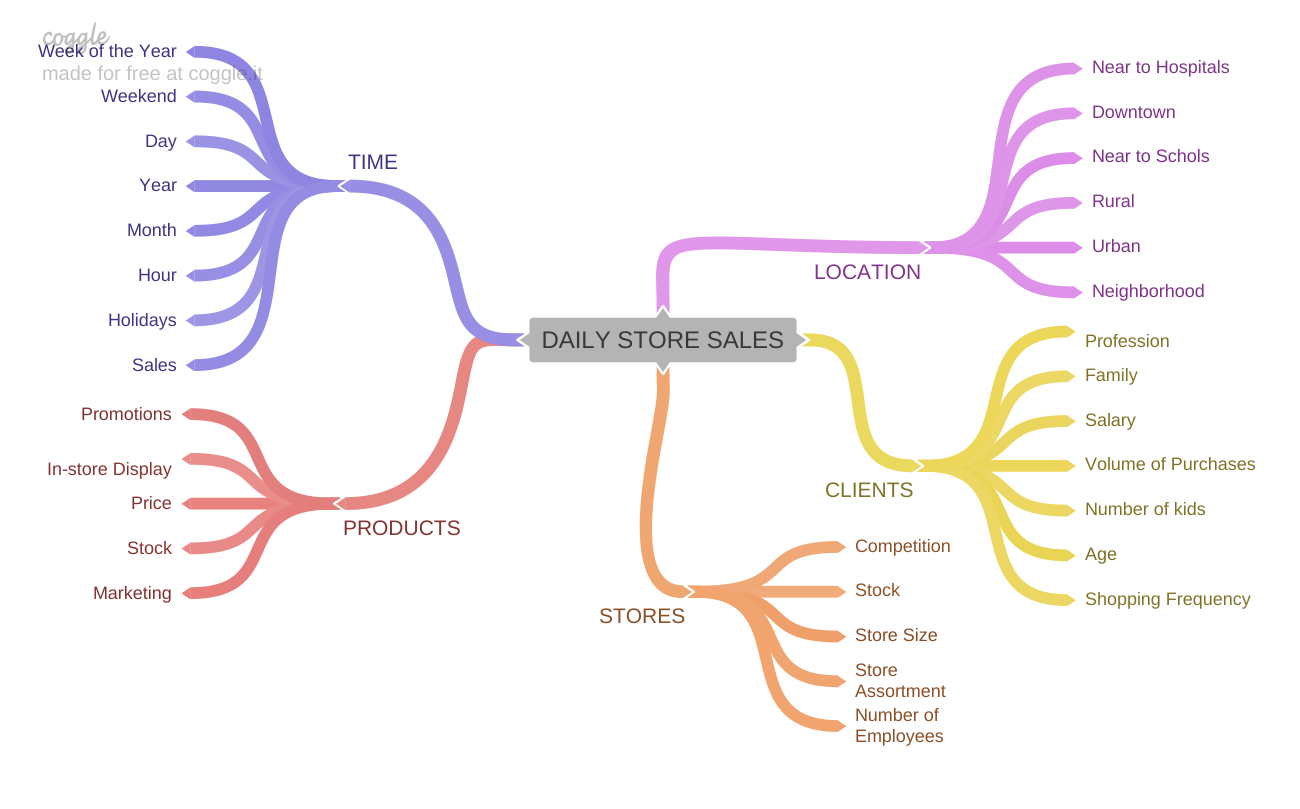

## Hypotesis Final List

**1.** Stores with a larger assortment should sell more.

**2.** Stores with closer competitors should sell less.

**3.** Stores with longer competitors should sell more.

**4.** Stores with active promotions for a longer time should sell more.

**5.** Stores with more promotion days should sell more.

**6.** Stores with more consecutive promotions should sell more.

**7.** Stores open during the Christmas holiday should sell more.

**8.** Stores should sell more over the years.

**9.** Stores should sell more in the second half of the year.

**10.** Stores should sell more after the 10th of each month.

**11.** Stores should sell less on weekends.

**12.** Stores should sell less on school holidays.


In [27]:
df2 = df1.copy() 

## Feature Enginnering

In [28]:
# year
df2['year'] = df2.date.dt.year

# month
df2['month'] = df2.date.dt.month

# day
df2['day'] = df2.date.dt.day

# week of year
df2['week_of_year'] = df2.date.dt.weekofyear

# year week
df2['year_week'] = df2.date.dt.strftime('%Y-%W')

# competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year = x['competition_open_since_year'] , month = x['competition_open_since_month'], day = 1), axis = 1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since']) / 30).apply(lambda x: x.days).astype('int64')
# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days = 7))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since']) / 7).apply(lambda x: x.days).astype('int64')

# assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

<ipython-input-28-c40bec070474>:11: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df2['week_of_year'] = df2.date.dt.weekofyear


## Filtering the Variables

In [29]:
df3 = df2.copy()
df3.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


## Rows Filtering

In [30]:
df3.shape

(1017209, 29)

In [31]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

In [32]:
df3.shape

(844338, 29)

## Columns Filtering

In [33]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis = 1)

In [34]:
df3.shape

(844338, 25)

# Exploratory Data Analysis

In [35]:
df4 = df3.copy()

## Univariate Analysis

### Response Variable

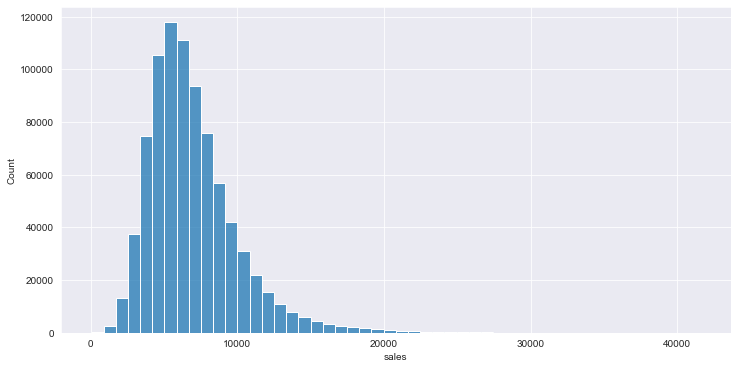

In [36]:
plt.figure(figsize = (12, 6))
sns.set_style('darkgrid')

sns.histplot(df4['sales'], kde = False, bins = 50);

### Numerical Variables

<Figure size 1152x432 with 0 Axes>

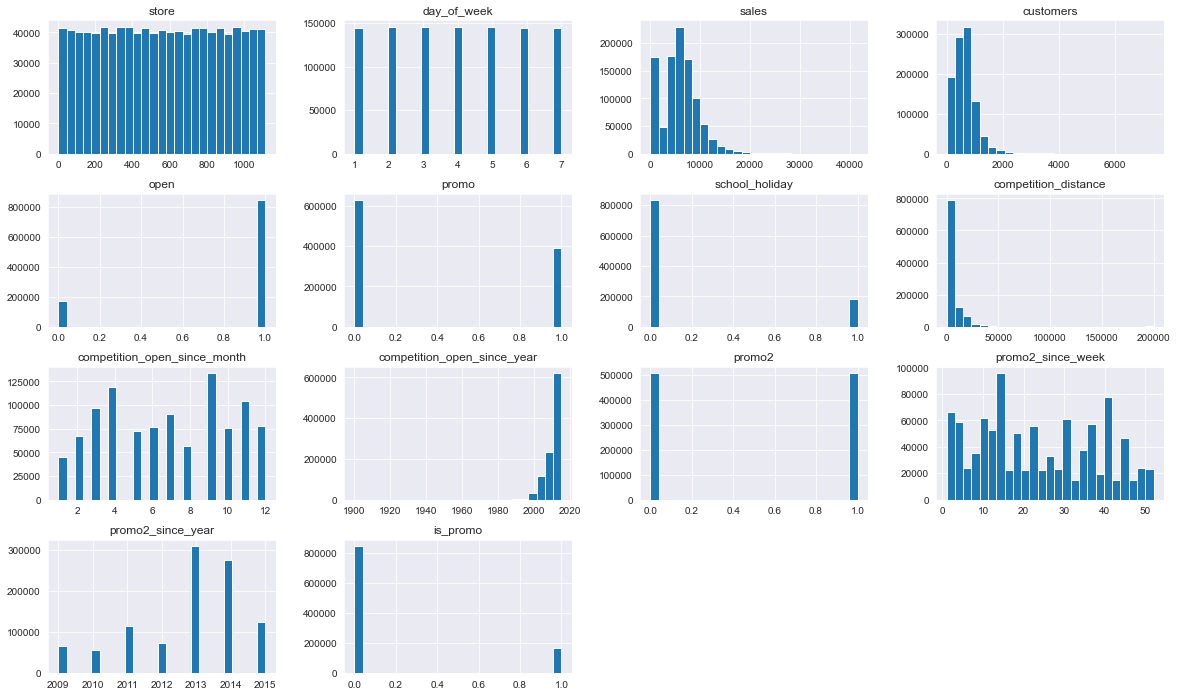

In [37]:
plt.figure(figsize = (16, 6))
num_attributes.hist(figsize = (20,12), bins = 25);

## Categorical Variables

In [38]:
display(df4['state_holiday'].drop_duplicates())
print('-=-'*30)
display(df4['store_type'].drop_duplicates())
print('-=-'*30)
display(df4['assortment'].drop_duplicates())

0            regular_day
63559     public_holiday
129424    easter_holiday
241126         christmas
Name: state_holiday, dtype: object

-=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=-


0     c
1     a
12    d
84    b
Name: store_type, dtype: object

-=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=-


0         basic
3      extended
258       extra
Name: assortment, dtype: object

In [39]:
display(df4['state_holiday'].value_counts())
print('-=-'*30)
display(df4['store_type'].value_counts())
print('-=-'*30)
display(df4['assortment'].value_counts())

regular_day       843428
public_holiday       694
easter_holiday       145
christmas             71
Name: state_holiday, dtype: int64

-=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=-


a    457042
d    258768
c    112968
b     15560
Name: store_type, dtype: int64

-=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=-


basic       444875
extended    391254
extra         8209
Name: assortment, dtype: int64

C:\Users\felip\Anaconda3\envs\DataScienceEmProducao\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\felip\Anaconda3\envs\DataScienceEmProducao\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\felip\Anaconda3\envs\DataScienceEmProducao\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result i

[]

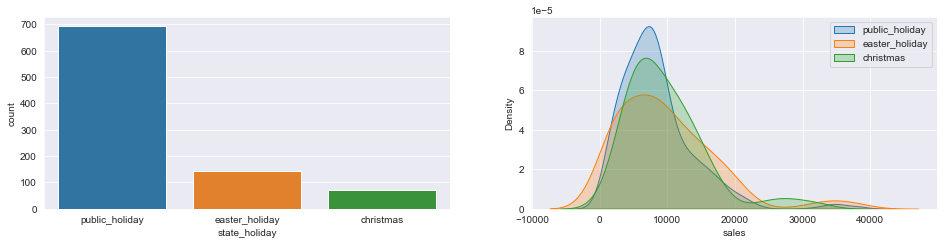

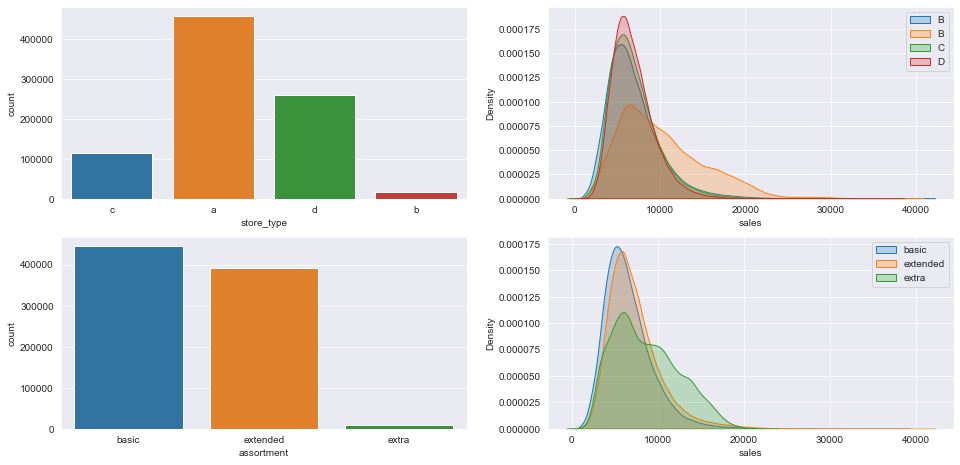

In [40]:
# state_holiday
a = df4[df4['state_holiday'] != 'regular_day']
plt.figure(figsize = (16, 12))
sns.set_style('darkgrid')

plt.subplot(3, 2, 1)
sns.countplot(a['state_holiday'])

plt.subplot(3, 2, 2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], shade = True, label = 'public_holiday')
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], shade = True, label = 'easter_holiday')
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], shade = True, label = 'christmas')
plt.legend()
plt.plot()

# store_type
plt.figure(figsize = (16, 12))
sns.set_style('darkgrid')

plt.subplot(3, 2, 3)
sns.countplot(df4['store_type'])

plt.subplot(3, 2, 4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], shade = True, label = 'B')
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], shade = True, label = 'B')
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], shade = True, label = 'C')
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], shade = True, label = 'D')
plt.legend()
plt.plot()
# assortment
plt.subplot(3, 2, 5)
sns.countplot(df4['assortment'])

plt.subplot(3, 2, 6)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], shade = True, label = 'basic')
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], shade = True, label = 'extended')
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], shade = True, label = 'extra')
plt.legend()
plt.plot()

In [41]:
basic = (df4[df4['assortment'] == 'basic']['sales']).mean()
extra = (df4[df4['assortment'] == 'extra']['sales']).mean()
extended  = (df4[df4['assortment'] == 'extended']['sales']).mean()

In [42]:
print(f'Average sales of the "basic" stores = {round(basic, 2)}')
print(f'Average sales of the "extra" stores = {round(extra, 2)}')
print(f'Average sales of the "extended" stores = {round(extended, 2)}')

Average sales of the "basic" stores = 6621.52
Average sales of the "extra" stores = 8642.5
Average sales of the "extended" stores = 7300.84


In [43]:
assortment_avg_sales = pd.DataFrame([round(basic, 2), round(extra, 2), round(extended, 2)],
                                    index = ['basic', 'extra', 'extended'])
assortment_avg_sales = assortment_avg_sales.T
assortment_avg_sales

,basic,extra,extended
0,6621.52,8642.5,7300.84


## Bivariate Analysis

### H1. Stores with a larger assortment should sell more.**

 **Assortment** - describes an assortment level: a = basic, b = extra, c = extended
 
According with the data, stores with assortment type "extra" have a bigger average sales in comparison with "basic" type and "extended" type.
 

In [44]:
aux1_sum = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
aux1_mean = df4[['assortment', 'sales']].groupby('assortment').mean().reset_index()
display(aux1_sum)
display(aux1_mean)

,assortment,sales
0,basic,2945750070
1,extended,2856484241
2,extra,70946312


,assortment,sales
0,basic,6621.523057
1,extended,7300.843547
2,extra,8642.503594


Text(0.5, 1.0, 'Average Sales by Assortment Type per Day')

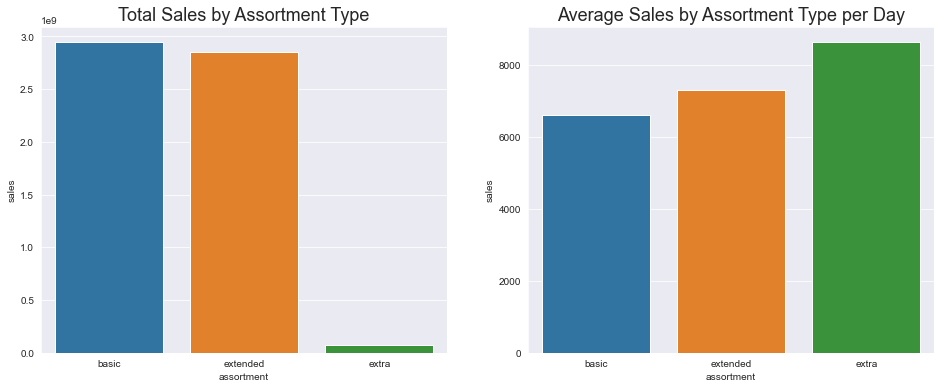

In [45]:
plt.figure(figsize = (16, 6))
plt.subplot(1, 2, 1)
sns.barplot(x = 'assortment', y= 'sales', data = aux1_sum);
plt.title('Total Sales by Assortment Type', fontsize = 18)

plt.subplot(1, 2, 2)
sns.barplot(x = 'assortment', y= 'sales', data = aux1_mean);
plt.title('Average Sales by Assortment Type per Day', fontsize = 18)

In [46]:
aux2_week_mean = df4[['year_week', 'assortment', 'sales']].groupby(['year_week','assortment']).mean().reset_index()
aux2_week_sum = df4[['year_week', 'assortment', 'sales']].groupby(['year_week','assortment']).sum().reset_index()

aux2_week_mean_pivot = aux2_week_mean.pivot(index = 'year_week', columns = 'assortment' , values = 'sales')
aux2_week_sum_pivot = aux2_week_sum.pivot(index = 'year_week', columns = 'assortment' , values = 'sales')

display(aux2_week_sum_pivot)
display(aux2_week_mean_pivot)

assortment,basic,extended,extra
year_week,,,
2013-00,13434262,12425669,269404
2013-01,26007250,22917693,350279
2013-02,17970974,16029584,377207
2013-03,24392076,21243431,404662
2013-04,19972891,18130077,363061
...,...,...,...
2015-26,27840342,27165959,684180
2015-27,20356210,20449036,586036
2015-28,25746704,25629698,632017


assortment,basic,extended,extra
year_week,,,
2013-00,5642.277194,6094.001471,5282.431373
2013-01,7307.459961,7553.623270,6254.982143
2013-02,5049.444788,5283.317073,6286.783333
2013-03,6853.631919,6983.376397,6423.206349
2013-04,5611.939028,5944.287541,6483.232143
...,...,...,...
2015-26,7807.162647,8788.728243,10860.000000
2015-27,5710.016830,6624.242306,9302.158730
2015-28,7238.319933,8299.772668,10032.015873


<AxesSubplot:xlabel='year_week'>

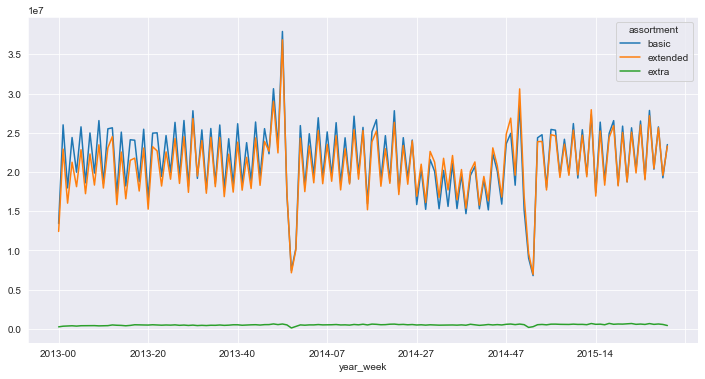

In [47]:
aux2_week_sum_pivot.plot(figsize = (12, 6))

Text(0.5, 1.0, 'Avg Sales by Assortment Type Store')

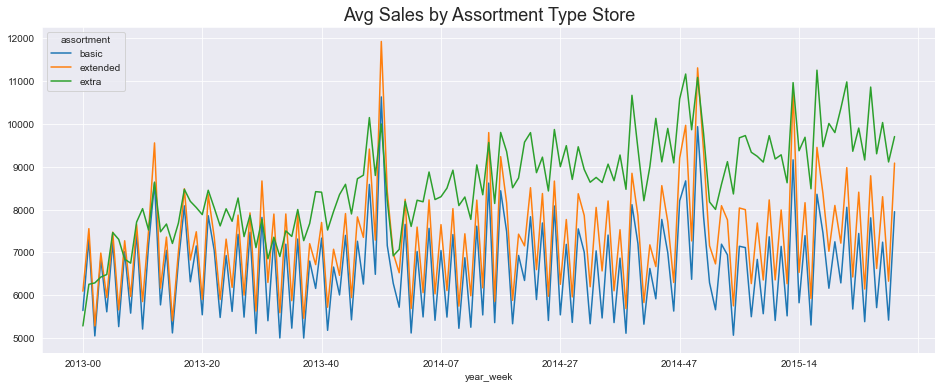

In [48]:
aux2_week_mean_pivot.plot(figsize = (16, 6))
plt.title('Avg Sales by Assortment Type Store', fontsize = 18)

### **H2. Stores with closer competitors should sell less.**

**CompetitionDistance** - distance in meters to the nearest competitor store

**False** - Stores with closer competitors tends to sell more, 
this is because stores with closest competitors are usually located in urban areas of larger cities, making sales better even with the proximity of competitors.

In [49]:
aux_sum = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()
aux_mean = df4[['competition_distance', 'sales']].groupby('competition_distance').mean().reset_index()

aux_sum.head()

,competition_distance,sales
0,20.0,4579807
1,30.0,17552666
2,40.0,29261626
3,50.0,60835848
4,60.0,22088359


In [50]:
bins = np.arange(0, 50000, 1000)

aux_sum['competition_distance_binned'] = pd.cut(aux_sum['competition_distance'], bins = bins)
aux_mean['competition_distance_binned'] = pd.cut(aux_mean['competition_distance'], bins = bins)

display(aux_sum)
display(aux_mean)

,competition_distance,sales,competition_distance_binned
0,20.0,4579807,"(0.0, 1000.0]"
1,30.0,17552666,"(0.0, 1000.0]"
2,40.0,29261626,"(0.0, 1000.0]"
3,50.0,60835848,"(0.0, 1000.0]"
4,60.0,22088359,"(0.0, 1000.0]"
...,...,...,...
650,46590.0,3554993,"(46000.0, 47000.0]"
651,48330.0,3798660,"(48000.0, 49000.0]"
652,58260.0,5718883,NaN
653,75860.0,6896821,NaN


,competition_distance,sales,competition_distance_binned
0,20.0,5879.084724,"(0.0, 1000.0]"
1,30.0,5634.884751,"(0.0, 1000.0]"
2,40.0,7526.138374,"(0.0, 1000.0]"
3,50.0,9735.293327,"(0.0, 1000.0]"
4,60.0,9431.408625,"(0.0, 1000.0]"
...,...,...,...
650,46590.0,4534.429847,"(46000.0, 47000.0]"
651,48330.0,4845.229592,"(48000.0, 49000.0]"
652,58260.0,6462.014689,NaN
653,75860.0,7775.446449,NaN


In [51]:
aux2_sum = aux_sum[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
aux2_mean = aux_mean[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').mean().reset_index()

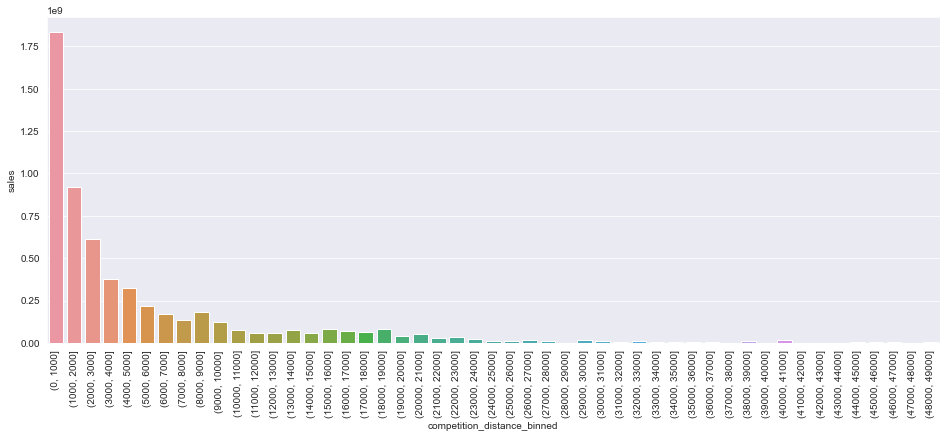

In [52]:
plt.figure(figsize = (16, 6))
sns.barplot(x = 'competition_distance_binned', y = 'sales', data = aux2_sum)
plt.xticks(rotation = 90);

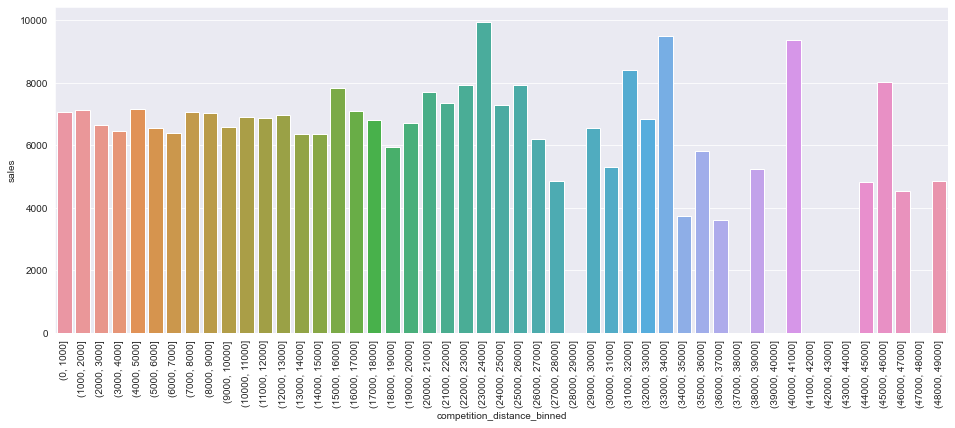

In [53]:
plt.figure(figsize = (16, 6))
sns.barplot(x = 'competition_distance_binned', y = 'sales', data = aux2_mean)
plt.xticks(rotation = 90);

In [54]:
aux_sum_closer = aux_sum[aux_sum['competition_distance'] < 50000]

<AxesSubplot:xlabel='competition_distance', ylabel='sales'>

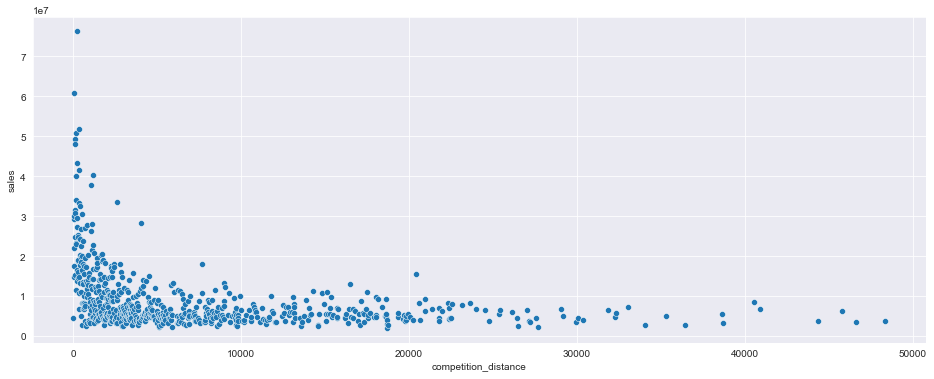

In [55]:
plt.figure(figsize=(16, 6))
sns.scatterplot(x = 'competition_distance', y = 'sales', data = aux_sum_closer)

In [56]:
aux_mean_closer = aux_mean[aux_mean['competition_distance'] < 50000]

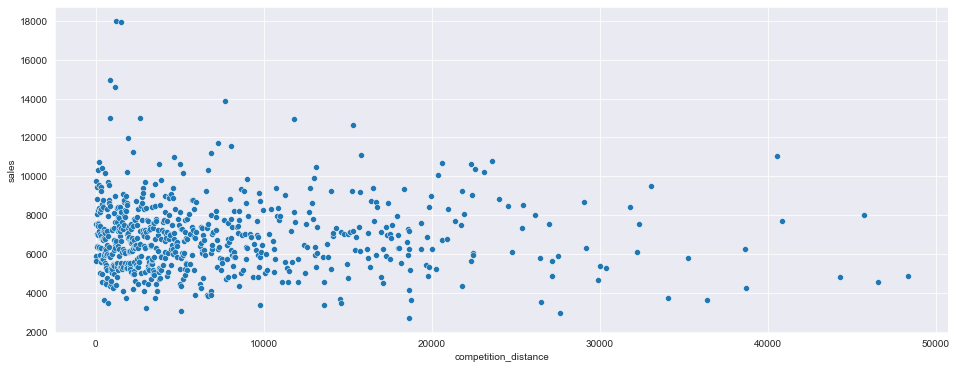

In [57]:
plt.figure(figsize=(16, 6))
sns.scatterplot(x = 'competition_distance', y = 'sales', data = aux_mean_closer);

In [58]:
aux_sum.head().T

,0,1,2,3,4
competition_distance,20.0,30.0,40.0,50.0,60.0
sales,4579807,17552666,29261626,60835848,22088359
competition_distance_binned,"(0, 1000]","(0, 1000]","(0, 1000]","(0, 1000]","(0, 1000]"


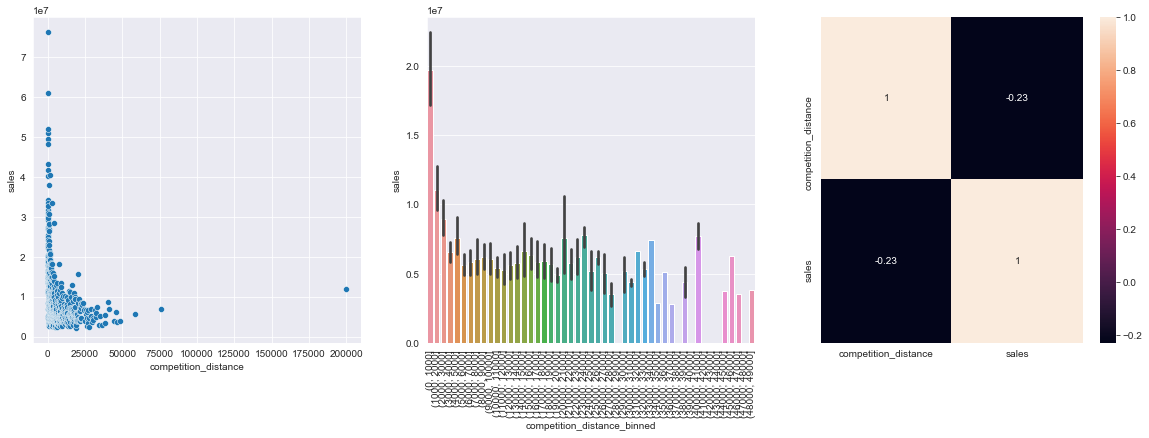

In [59]:
plt.figure(figsize = (20, 6))

plt.subplot(1, 3, 1)
sns.scatterplot(x = 'competition_distance', y = 'sales', data = aux_sum);

plt.subplot(1, 3, 2)
sns.barplot(x = 'competition_distance_binned', y = 'sales', data = aux_sum);
plt.xticks(rotation = 90)

plt.subplot(1, 3, 3)
sns.heatmap(aux_sum.corr(method = 'pearson'), annot = True);

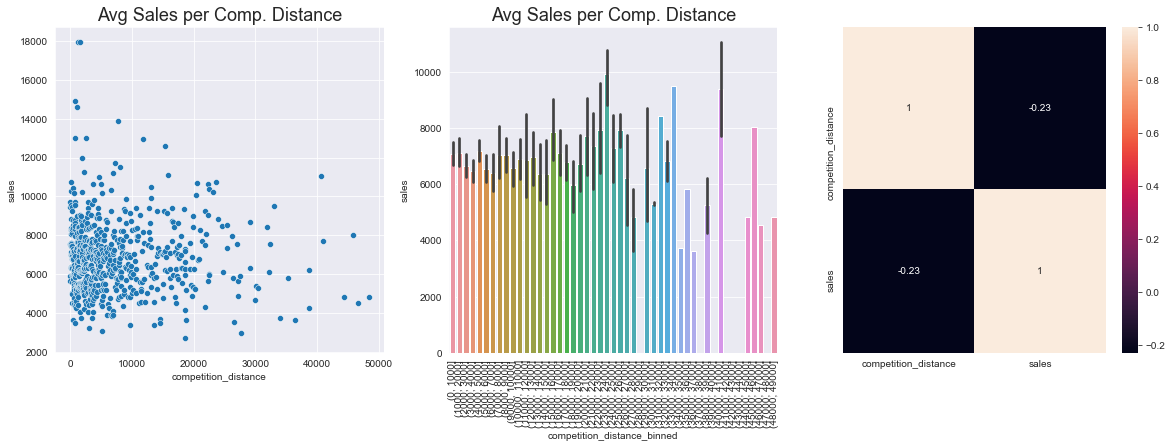

In [60]:
plt.figure(figsize = (20, 6))

plt.subplot(1, 3, 1)
sns.scatterplot(x = 'competition_distance', y = 'sales', data = aux_mean_closer);
plt.title('Avg Sales per Comp. Distance', fontsize = 18)

plt.subplot(1, 3, 2)
sns.barplot(x = 'competition_distance_binned', y = 'sales', data = aux_mean_closer);
plt.title('Avg Sales per Comp. Distance', fontsize = 18)
plt.xticks(rotation = 90)

plt.subplot(1, 3, 3)
sns.heatmap(aux_sum.corr(method = 'pearson'), annot = True);

### **H3. Stores with longer open competitors are expected to sell more.**

**CompetitionOpenSince[Month/Year]** - gives the approximate year and month of the time the nearest competitor was opened

**True** - Stores with longer time open competitors have better average sales then stores with less time competitor's open.

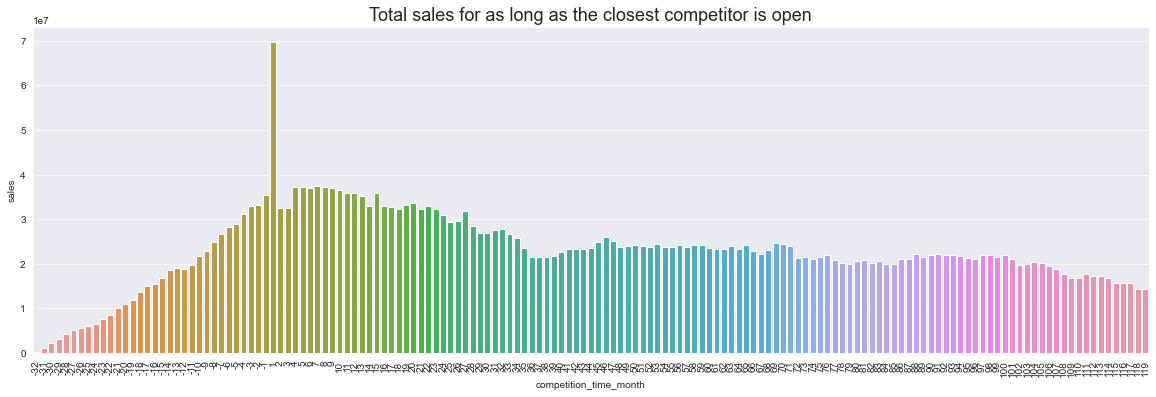

In [61]:
plt.figure(figsize = (20, 6))

aux_mean = df4[['competition_time_month', 'sales']].groupby('competition_time_month').mean().reset_index()
aux_mean_2 = aux_mean[(aux_mean['competition_time_month'] < 120) & (aux_mean['competition_time_month'] != 0)]
aux_sum = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux_sum_2 = aux_sum[(aux_sum['competition_time_month'] < 120) & (aux_sum['competition_time_month'] != 0)]


sns.barplot(x = 'competition_time_month', y = 'sales', data = aux_sum_2);
plt.title('Total sales for as long as the closest competitor is open', fontsize = 18)
plt.xticks(rotation = 90);

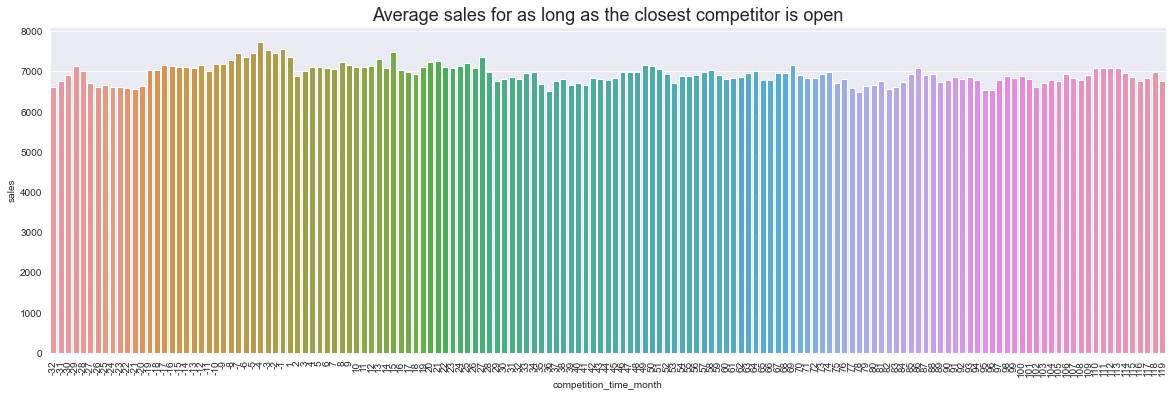

In [62]:
plt.figure(figsize = (20, 6))
sns.barplot(x = 'competition_time_month', y = 'sales', data = aux_mean_2);
plt.title('Average sales for as long as the closest competitor is open', fontsize = 18)
plt.xticks(rotation = 90);

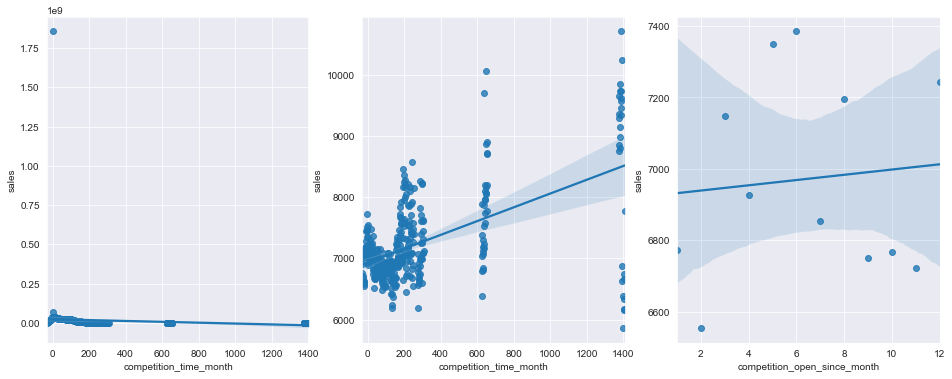

In [63]:
aux2_mean = df4[['competition_open_since_month', 'sales']].groupby('competition_open_since_month').mean().reset_index()
plt.figure(figsize = (16, 6))

plt.subplot(1, 3, 1)
sns.regplot(x = 'competition_time_month', y = 'sales', data = aux_sum);

plt.subplot(1, 3, 2)
sns.regplot(x = 'competition_time_month', y = 'sales' ,data = aux_mean);

plt.subplot(1, 3, 3)
sns.regplot(x = 'competition_open_since_month', y = 'sales' ,data = aux2_mean);

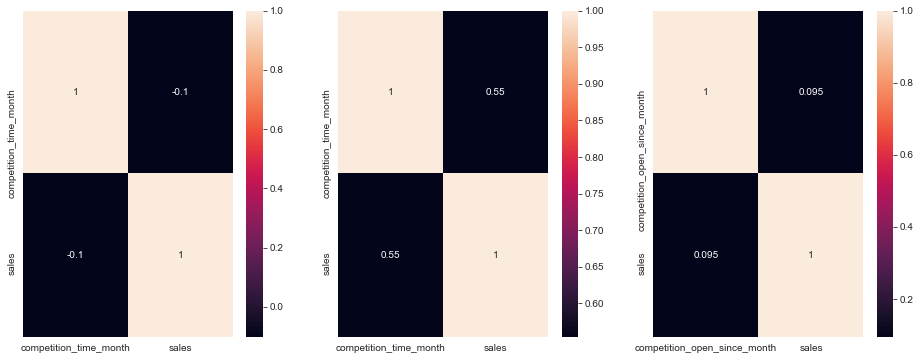

In [64]:
aux2_mean = df4[['competition_open_since_month', 'sales']].groupby('competition_open_since_month').mean().reset_index()

plt.figure(figsize = (16, 6))

plt.subplot(1, 3, 1)
sns.heatmap(aux_sum.corr(method = 'pearson'), annot = True);

plt.subplot(1, 3, 2)
sns.heatmap(aux_mean.corr(method = 'pearson'), annot = True);

plt.subplot(1, 3, 3)
sns.heatmap(aux2_mean.corr(method = 'pearson'), annot = True);

### **H4.** Stores with active promotions for a longer time should sell more.

**FALSE** - Apparently stores with promotions for more time have no better or worst sales than stores with less promotions time.

In [65]:
aux_sum = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

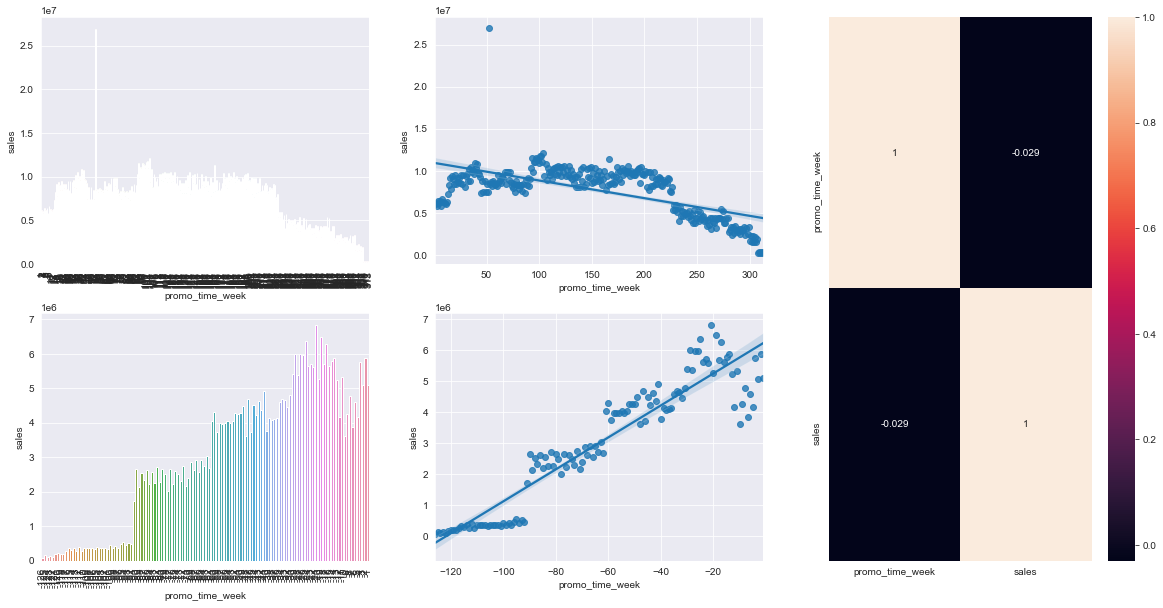

In [66]:
plt.figure(figsize = (20, 10))

grid = plt.GridSpec(2, 3)

plt.subplot(grid[0, 0])
aux1 = aux_sum[aux_sum['promo_time_week'] > 0]  #extended promo
sns.barplot(x = 'promo_time_week', y = 'sales', data = aux1);
plt.xticks(rotation = 90);

plt.subplot(grid[0, 1])
sns.regplot(x = 'promo_time_week', y = 'sales', data = aux1);

plt.subplot(grid[1, 0])
aux2 = aux_sum[aux_sum['promo_time_week'] < 0]
sns.barplot(x = 'promo_time_week', y = 'sales', data = aux2);
plt.xticks(rotation = 90);

plt.subplot(grid[1, 1])
sns.regplot(x = 'promo_time_week', y = 'sales', data = aux2);

plt.subplot(grid[:, 2])
sns.heatmap(aux_sum.corr(method = 'pearson'), annot = True);

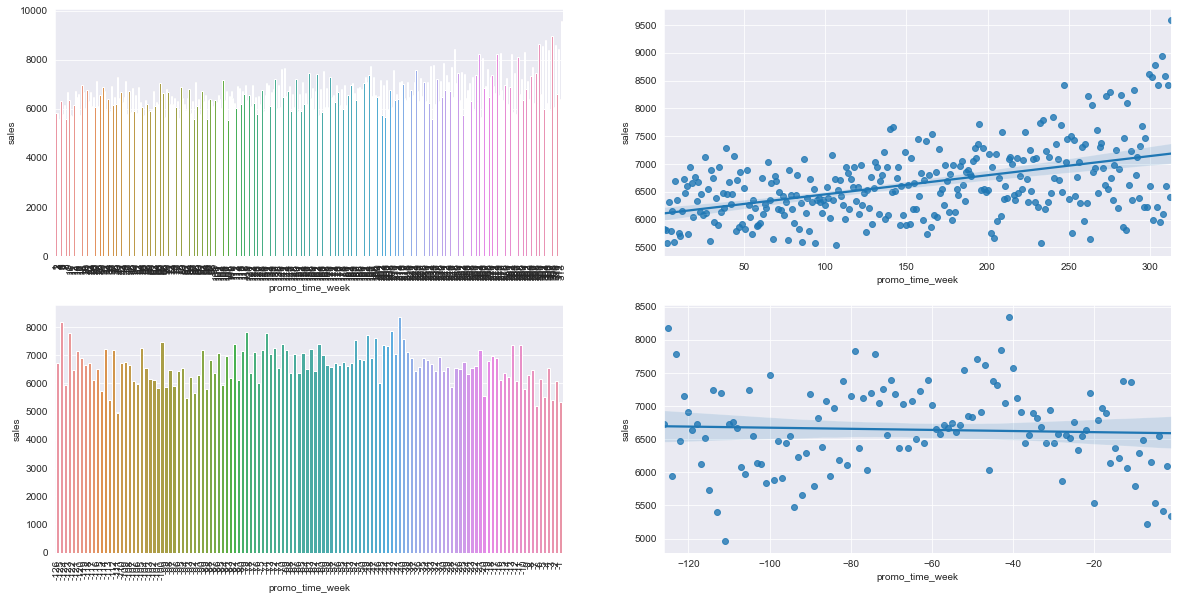

In [67]:
aux_mean = df4[['promo_time_week', 'sales']].groupby('promo_time_week').mean().reset_index()

plt.figure(figsize = (20, 10))

plt.subplot(2, 2, 1)
aux1 = aux_mean[aux_mean['promo_time_week'] > 0]  #extended promo
sns.barplot(x = 'promo_time_week', y = 'sales', data = aux1);
plt.xticks(rotation = 90);

plt.subplot(2, 2, 2)
sns.regplot(x = 'promo_time_week', y = 'sales', data = aux1);

plt.subplot(2, 2, 3)
aux2 = aux_mean[aux_mean['promo_time_week'] < 0]
sns.barplot(x = 'promo_time_week', y = 'sales', data = aux2);
plt.xticks(rotation = 90);

plt.subplot(2, 2, 4)
sns.regplot(x = 'promo_time_week', y = 'sales', data = aux2);

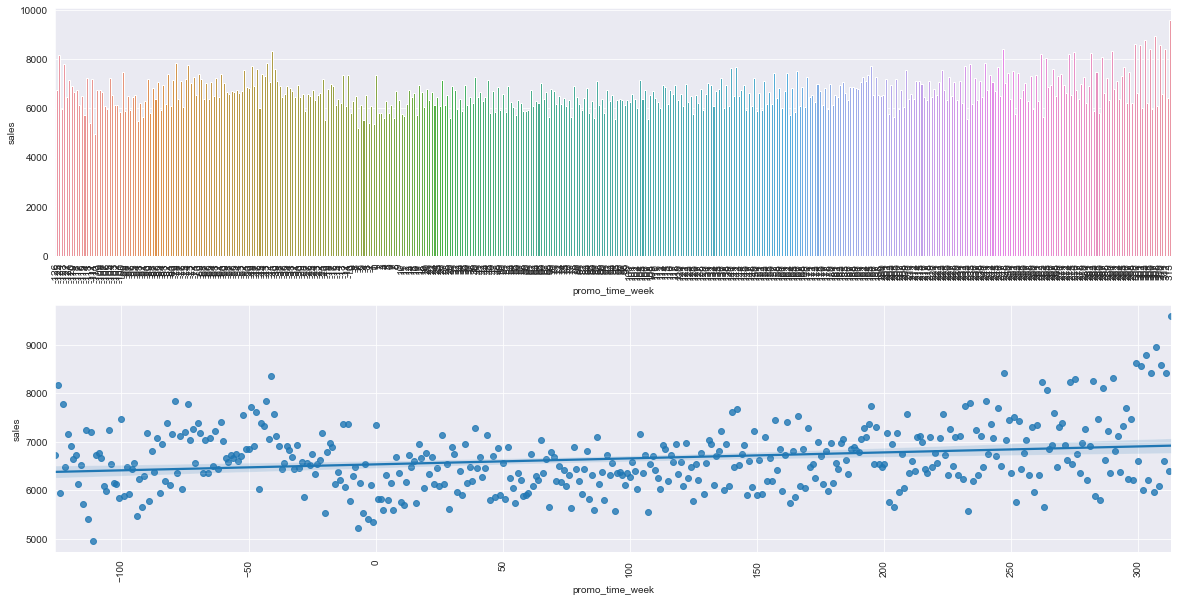

In [68]:
plt.figure(figsize = (20, 10))

plt.subplot(2, 1, 1)
sns.barplot(x = 'promo_time_week', y = 'sales', data = aux_mean);
plt.xticks(rotation = 90);

plt.subplot(2, 1, 2)
sns.regplot(x = 'promo_time_week', y = 'sales', data = aux_mean);
plt.xticks(rotation = 90);

### <s>**H5.** Stores with more promotion days should sell more.</s>

### **H6.** Stores with more consecutive promotions should sell more.

**FALSE** - Stores with more consecutive promotions tends to sell less.

In [69]:
display(df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index())
display(df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).mean().reset_index())

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


,promo,promo2,sales
0,0,0,6328.187633
1,0,1,5529.566684
2,1,0,8618.452062
3,1,1,7836.672987


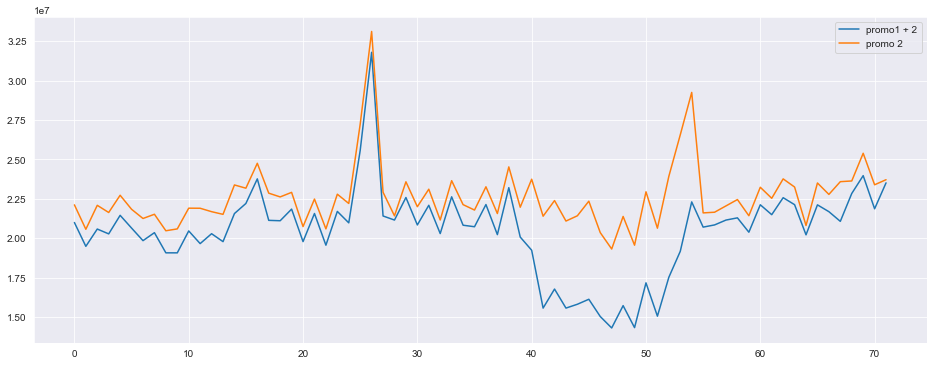

In [70]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux1_2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot(figsize = (16, 6))
aux1_2.plot(figsize = (16, 6), ax = ax)

plt.legend(labels = ['promo1 + 2', 'promo 2'])

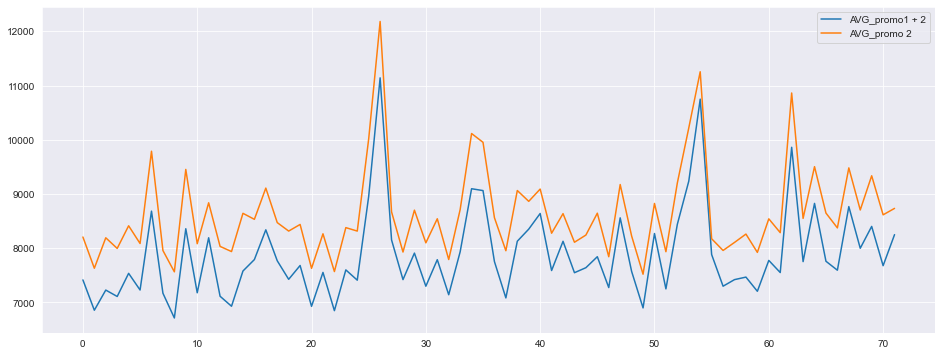

In [71]:
aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').mean().reset_index()
aux2_2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').mean().reset_index()
ax = aux2.plot(figsize = (16, 6))
aux2_2.plot(figsize = (16, 6), ax = ax)

plt.legend(labels = ['AVG_promo1 + 2', 'AVG_promo 2'])

### **H7.** Stores open during the Christmas holiday should sell more.

   **True** - The average sales during christmas and easter holiday are much better than in a regular day. 
   Something like 42% better.

In [72]:
aux_sum = df4[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
aux_mean = df4[['state_holiday', 'sales']].groupby('state_holiday').mean().reset_index()
aux = df4[df4['state_holiday'] != 'regular_day']
aux_no_regular_day = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()

In [73]:
df4['state_holiday'].value_counts()

regular_day       843428
public_holiday       694
easter_holiday       145
christmas             71
Name: state_holiday, dtype: int64

In [74]:
display(aux_sum.head())
display(aux_mean.head())

,state_holiday,sales
0,christmas,691806
1,easter_holiday,1433744
2,public_holiday,5890305
3,regular_day,5865164768


,state_holiday,sales
0,christmas,9743.746479
1,easter_holiday,9887.889655
2,public_holiday,8487.471182
3,regular_day,6953.960229


In [75]:
(aux_mean['sales'][1] * 100) / aux_mean['sales'][3]

142.19077086433794

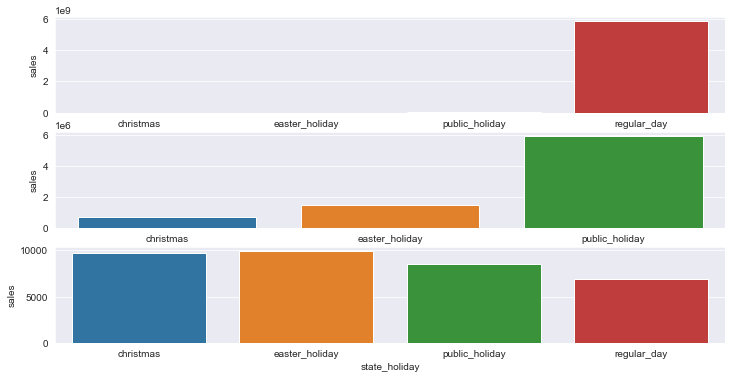

In [76]:
plt.figure(figsize = (12, 6))

plt.subplot(3, 1, 1)
sns.barplot(x = 'state_holiday', y = 'sales', data = aux_sum);

plt.subplot(3, 1, 2)
sns.barplot(x = 'state_holiday', y = 'sales', data = aux_no_regular_day);

plt.subplot(3, 1, 3)
sns.barplot(x = 'state_holiday', y = 'sales', data = aux_mean);

In [77]:
df4['state_holiday'].value_counts()

regular_day       843428
public_holiday       694
easter_holiday       145
christmas             71
Name: state_holiday, dtype: int64

In [78]:
aux2_sum = aux[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
aux2_mean = df4[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).mean().reset_index()

display(aux2_sum)
display(aux2_mean)

,year,state_holiday,sales
0,2013,christmas,331182
1,2013,easter_holiday,454997
2,2013,public_holiday,2052408
3,2014,christmas,360624
4,2014,easter_holiday,463353
5,2014,public_holiday,2084616
6,2015,easter_holiday,515394
7,2015,public_holiday,1753281


,year,state_holiday,sales
0,2013,christmas,9199.500000
1,2013,easter_holiday,9680.787234
2,2013,public_holiday,7863.632184
3,2013,regular_day,6813.310910
4,2014,christmas,10303.542857
5,2014,easter_holiday,9456.183673
6,2014,public_holiday,8685.900000
7,2014,regular_day,7024.089786
8,2015,easter_holiday,10518.244898
9,2015,public_holiday,9084.357513


Text(0.5, 1.0, 'Average Sales per State Holiday')

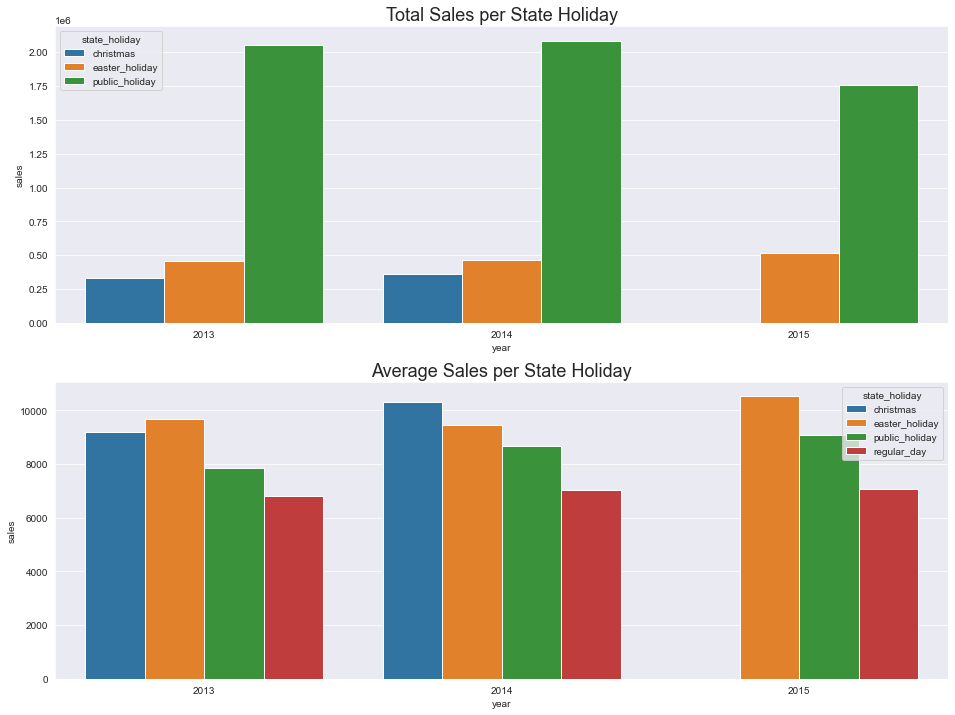

In [79]:
plt.figure(figsize = (16, 12))

plt.subplot(2, 1, 1)
sns.barplot(x = 'year', y = 'sales', hue = 'state_holiday', data = aux2_sum);
plt.title('Total Sales per State Holiday', fontsize = 18)

plt.subplot(2, 1, 2)
sns.barplot(x = 'year', y = 'sales', hue = 'state_holiday', data = aux2_mean);
plt.title('Average Sales per State Holiday', fontsize = 18)

### **H8.** Stores should sell more over the years.

**TRUE** - The average sales is better over the years.

In [80]:
aux_sum = df4[['year', 'sales']].groupby('year').sum().reset_index()
aux_mean = df4[['year', 'sales']].groupby('year').mean().reset_index()
aux_mean['sales'] = round(aux_mean['sales'], 2)
aux_mean.rename(columns = {'sales':'avg_sales'}, inplace = True)

display(aux_sum)
display(aux_mean)

,year,sales
0,2013,2302876084
1,2014,2180804896
2,2015,1389499643


,year,avg_sales
0,2013,6814.78
1,2014,7026.13
2,2015,7088.24


Text(0.5, 1.0, 'Average Sales X Year')

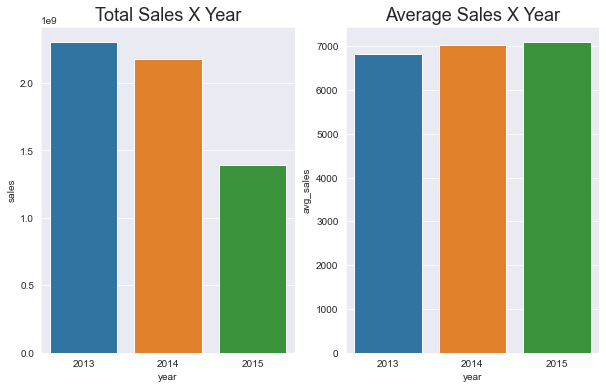

In [81]:
plt.figure(figsize = (10, 6))

plt.subplot(1, 2, 1)
sns.barplot(x = 'year', y = 'sales', data = aux_sum);
plt.title('Total Sales X Year', fontsize = 18)

plt.subplot(1, 2, 2)
sns.barplot(x = 'year', y = 'avg_sales', data = aux_mean);
plt.title('Average Sales X Year', fontsize = 18)

In [82]:
df4['year'].value_counts()

2013    337924
2014    310385
2015    196029
Name: year, dtype: int64

In [83]:
df4.date.max()

Timestamp('2015-07-31 00:00:00')

Text(0.5, 1.0, 'Average Sales Corr Map')

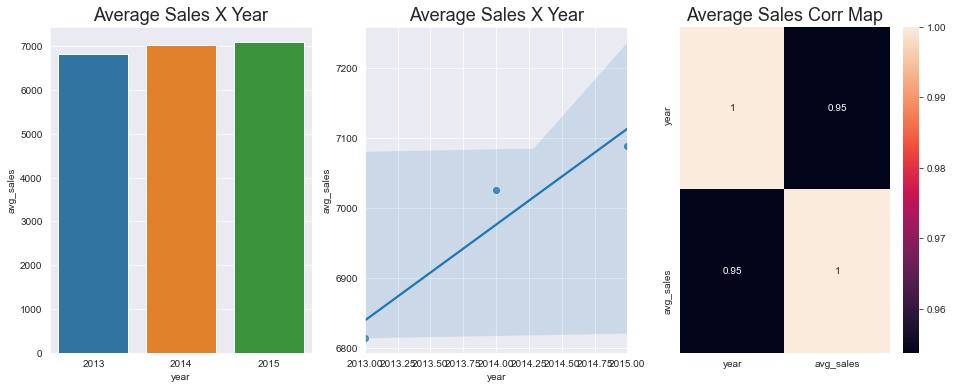

In [84]:
plt.figure(figsize = (16, 6))

plt.subplot(1, 3, 1)
sns.barplot(x = 'year', y = 'avg_sales', data = aux_mean);
plt.title('Average Sales X Year', fontsize = 18)

plt.subplot(1, 3, 2)
sns.regplot(x = 'year', y = 'avg_sales', data = aux_mean);
plt.title('Average Sales X Year', fontsize = 18)

plt.subplot(1, 3, 3)
sns.heatmap(aux_mean.corr(method = 'pearson'), annot = True);
plt.title('Average Sales Corr Map', fontsize = 18)

### **H9.** Stores should sell more in the second half of the year.

**INCONCLUSIVE** - according the data there is a balance during the months, with some elevation of average sales between March and July, but not much. Only December has a major average sales increase.

In [85]:
aux_sum = df4[['month', 'sales']].groupby('month').sum().reset_index()
aux_mean = df4[['month', 'sales']].groupby('month').mean().reset_index()
aux_mean['sales'] = round(aux_mean['sales'], 2)
aux_mean.rename(columns = {'sales':'avg_sales'}, inplace = True)

#display(aux_sum)
#display(aux_mean)

Text(0.5, 1.0, 'Total Sales Corr Map')

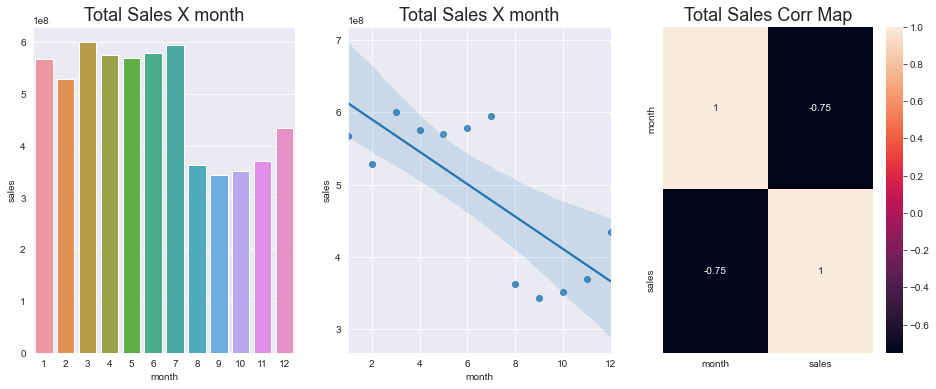

In [86]:
plt.figure(figsize = (16, 6))

plt.subplot(1, 3, 1)
sns.barplot(x = 'month', y = 'sales', data = aux_sum);
plt.title('Total Sales X month', fontsize = 18)

plt.subplot(1, 3, 2)
sns.regplot(x = 'month', y = 'sales', data = aux_sum);
plt.title('Total Sales X month', fontsize = 18)

plt.subplot(1, 3, 3)
sns.heatmap(aux_sum.corr(method = 'pearson'), annot = True);
plt.title('Total Sales Corr Map', fontsize = 18)

Text(0.5, 1.0, 'Average Sales Corr Map')

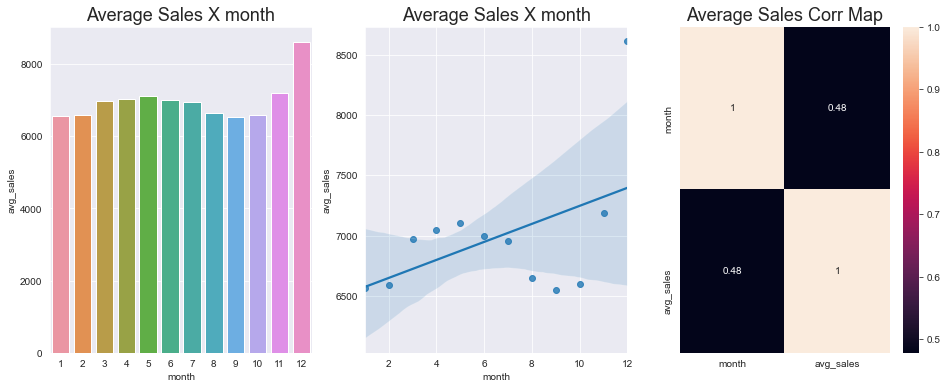

In [87]:
plt.figure(figsize = (16, 6))

plt.subplot(1, 3, 1)
sns.barplot(x = 'month', y = 'avg_sales', data = aux_mean);
plt.title('Average Sales X month', fontsize = 18)

plt.subplot(1, 3, 2)
sns.regplot(x = 'month', y = 'avg_sales', data = aux_mean);
plt.title('Average Sales X month', fontsize = 18)

plt.subplot(1, 3, 3)
sns.heatmap(aux_mean.corr(method = 'pearson'), annot = True);
plt.title('Average Sales Corr Map', fontsize = 18)

### **H10.** Stores should sell more after the 10th of each month.

**INCONCLUSIVE**

In [88]:
aux_sum = df4[['day', 'sales']].groupby('day').sum().reset_index()
aux_mean = df4[['day', 'sales']].groupby('day').mean().reset_index()
aux_mean['sales'] = round(aux_mean['sales'], 2)
aux_mean.rename(columns = {'sales':'avg_sales'}, inplace = True)

Text(0.5, 1.0, 'Total Sales Corr Map')

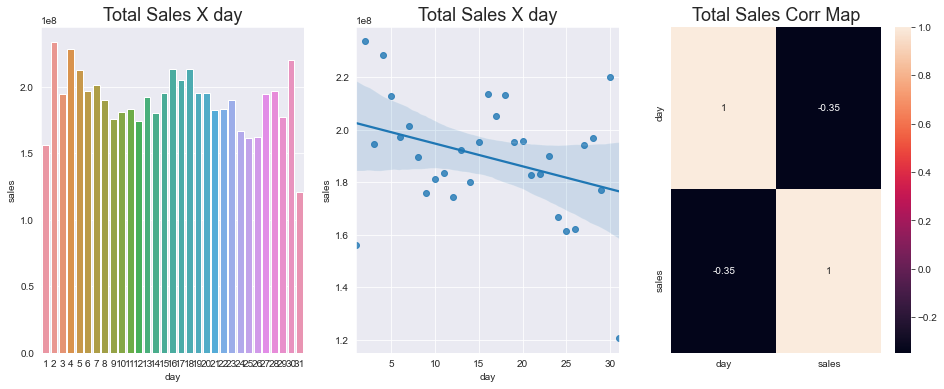

In [89]:
plt.figure(figsize = (16, 6))

plt.subplot(1, 3, 1)
sns.barplot(x = 'day', y = 'sales', data = aux_sum);
plt.title('Total Sales X day', fontsize = 18)

plt.subplot(1, 3, 2)
sns.regplot(x = 'day', y = 'sales', data = aux_sum);
plt.title('Total Sales X day', fontsize = 18)

plt.subplot(1, 3, 3)
sns.heatmap(aux_sum.corr(method = 'pearson'), annot = True);
plt.title('Total Sales Corr Map', fontsize = 18)

Text(0.5, 1.0, 'Average Sales Corr Map')

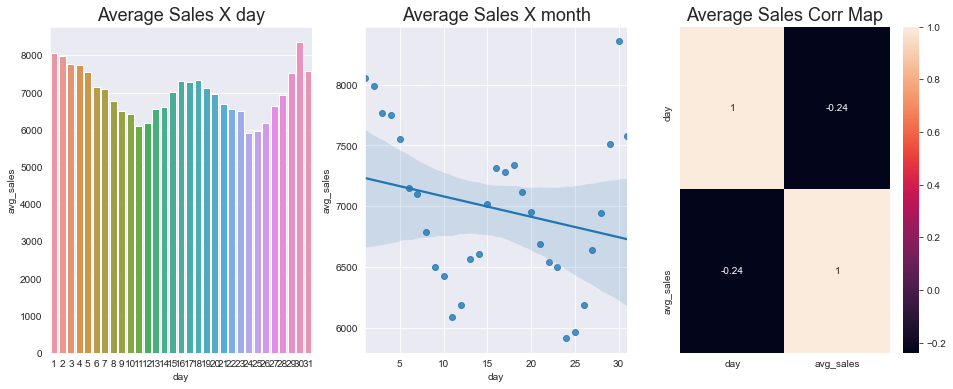

In [90]:
plt.figure(figsize = (16, 6))

plt.subplot(1, 3, 1)
sns.barplot(x = 'day', y = 'avg_sales', data = aux_mean);
plt.title('Average Sales X day', fontsize = 18)

plt.subplot(1, 3, 2)
sns.regplot(x = 'day', y = 'avg_sales', data = aux_mean);
plt.title('Average Sales X month', fontsize = 18)

plt.subplot(1, 3, 3)
sns.heatmap(aux_mean.corr(method = 'pearson'), annot = True);
plt.title('Average Sales Corr Map', fontsize = 18)

In [91]:
aux_sum['before_after_10th_day'] = aux_sum['day'].apply(lambda x: 'before_10th_day' if x <= 10 else 'after_10th_day')
aux_mean['before_after_10th_day'] = aux_mean['day'].apply(lambda x: 'before_10th_day' if x <= 10 else 'after_10th_day')

In [92]:
aux_sum_2 = aux_sum[['before_after_10th_day', 'sales']].groupby('before_after_10th_day').sum().reset_index()

<AxesSubplot:xlabel='before_after_10th_day', ylabel='sales'>

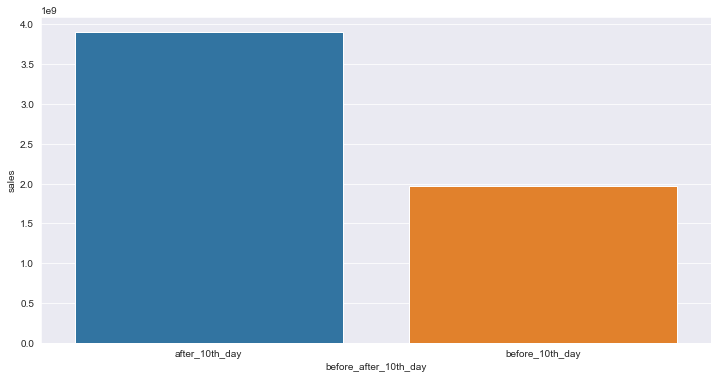

In [93]:
plt.figure(figsize = (12, 6))

sns.barplot(x = 'before_after_10th_day', y = 'sales', data = aux_sum_2)

In [94]:
display(aux_sum_2)
print(3902775310 / 20)
print(1970405313 / 10)

,before_after_10th_day,sales
0,after_10th_day,3902775310
1,before_10th_day,1970405313


195138765.5
197040531.3


<AxesSubplot:>

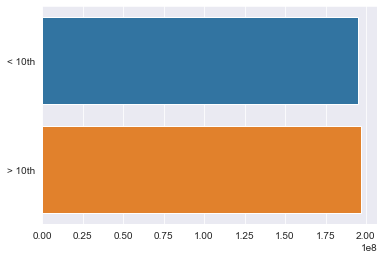

In [95]:
x = [195138765.5, 197040531.3]
y = ['< 10th', '> 10th']

sns.barplot(x = x, y = y)

### **H11.** Stores should sell less on weekends.

**FALSE** - Stores sell less on weekends.

In [96]:
aux_sum = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()
aux_mean = df4[['day_of_week', 'sales']].groupby('day_of_week').mean().reset_index()
aux_mean['sales'] = round(aux_mean['sales'], 2)
aux_mean.rename(columns = {'sales':'avg_sales'}, inplace = True)

Text(0.5, 1.0, 'Total Sales Corr Map')

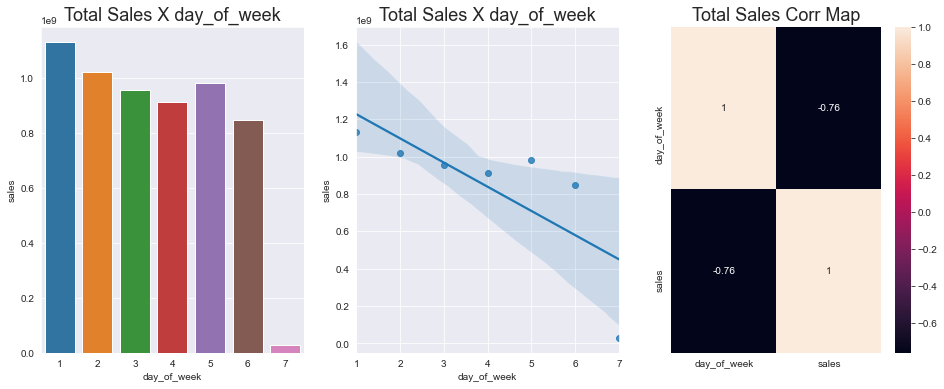

In [97]:
plt.figure(figsize = (16, 6))

plt.subplot(1, 3, 1)
sns.barplot(x = 'day_of_week', y = 'sales', data = aux_sum);
plt.title('Total Sales X day_of_week', fontsize = 18)

plt.subplot(1, 3, 2)
sns.regplot(x = 'day_of_week', y = 'sales', data = aux_sum);
plt.title('Total Sales X day_of_week', fontsize = 18)

plt.subplot(1, 3, 3)
sns.heatmap(aux_sum.corr(method = 'pearson'), annot = True);
plt.title('Total Sales Corr Map', fontsize = 18)

### **H12.** Stores should sell less on school holidays.

**INCONCLUSIVE** - The total sales amount in a not school holiday is bigger, but stores who are open in a school holiday tends to have a average sell better.

In [98]:
aux_SH_sum = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
aux_SH_mean = df4[['school_holiday', 'sales']].groupby('school_holiday').mean().reset_index()

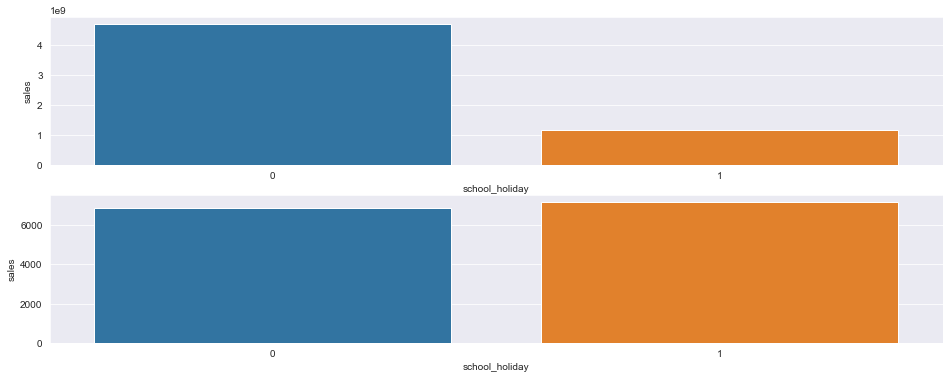

In [99]:
plt.figure(figsize = (16, 6))

plt.subplot(2, 1, 1)
sns.barplot(x = 'school_holiday', y = 'sales', data = aux_SH_sum);

plt.subplot(2, 1, 2)
sns.barplot(x = 'school_holiday', y = 'sales', data = aux_SH_mean);

In [100]:
aux_SH_sum_2 = df4[['month', 'school_holiday', 'sales']].groupby(['month', 'school_holiday']).sum().reset_index()
aux_SH_mean_2 = df4[['month', 'school_holiday', 'sales']].groupby(['month','school_holiday']).mean().reset_index()

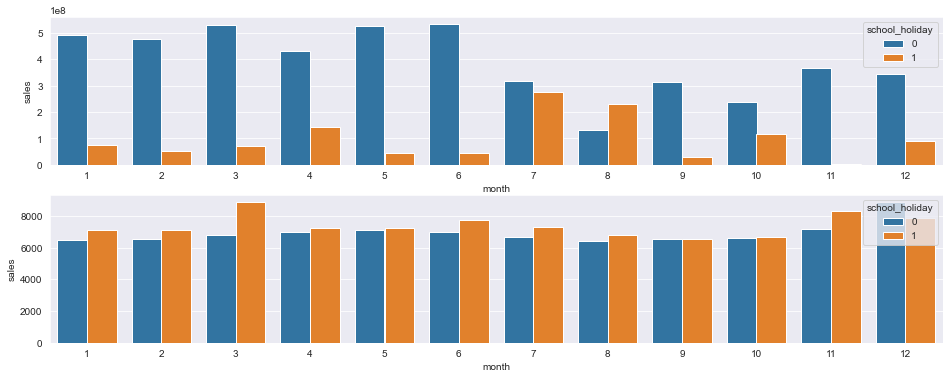

In [101]:
plt.figure(figsize = (16, 6))

plt.subplot(2, 1, 1)
sns.barplot(x = 'month', y = 'sales', hue = 'school_holiday', data = aux_SH_sum_2);

plt.subplot(2, 1, 2)
sns.barplot(x = 'month', y = 'sales', hue = 'school_holiday', data = aux_SH_mean_2);

## Multivariate Analysis

### Numerical Attributes

In [109]:
num_attributes.head()

,store,day_of_week,sales,customers,open,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo
0,1,5,5263,555,1,1,1,1270.0,9,2008,0,31,2015,0
1,2,5,6064,625,1,1,1,570.0,11,2007,1,13,2010,1
2,3,5,8314,821,1,1,1,14130.0,12,2006,1,14,2011,1
3,4,5,13995,1498,1,1,1,620.0,9,2009,0,31,2015,0
4,5,5,4822,559,1,1,1,29910.0,4,2015,0,31,2015,0


<AxesSubplot:>

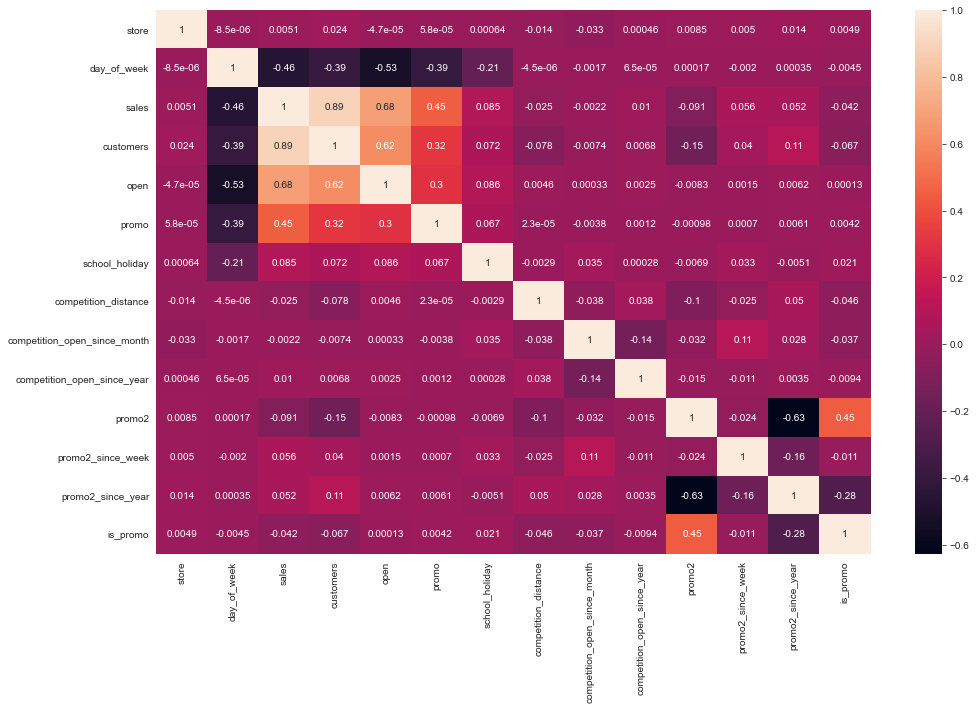

In [116]:
correlation = num_attributes.corr(method = 'pearson')

plt.figure(figsize = (16, 10))
sns.heatmap(correlation, annot = True)

### Categorical Attributes

In [118]:
aux = df4.select_dtypes(include = 'object')
aux.head()

,state_holiday,store_type,assortment,year_week
0,regular_day,c,basic,2015-30
1,regular_day,a,basic,2015-30
2,regular_day,a,basic,2015-30
3,regular_day,c,extended,2015-30
4,regular_day,a,basic,2015-30


Crammer's V calc:

In [129]:
cm = pd.crosstab(aux['state_holiday'], aux['store_type']).values
cm

array([[     4,     66,      0,      1],
       [    36,    100,      0,      9],
       [   236,    285,     65,    108],
       [456766,  15109, 112903, 258650]], dtype=int64)

In [123]:
aux[(aux['state_holiday'] == 'christmas') & (aux['store_type'] == 'a')]

,state_holiday,store_type,assortment,year_week
241499,christmas,a,extended,2014-51
241977,christmas,a,extended,2014-51
616339,christmas,a,extended,2013-51
616908,christmas,a,extended,2013-51


In [162]:
a1 = cramer_v(aux['state_holiday'], aux['state_holiday'])
a2 = cramer_v(aux['state_holiday'], aux['store_type'])
a3 = cramer_v(aux['state_holiday'], aux['assortment'])

a4 = cramer_v(aux['store_type'], aux['state_holiday'])
a5 = cramer_v(aux['store_type'], aux['store_type'])
a6 = cramer_v(aux['store_type'], aux['assortment'])

a7 = cramer_v(aux['assortment'], aux['state_holiday'])
a8 = cramer_v(aux['assortment'], aux['store_type'])
a9 = cramer_v(aux['assortment'], aux['assortment'])

d = pd.DataFrame({'state_holiday': [a1, a2, a3],
              'store_type': [a4, a5, a6],
              'assortment': [a7, a8, a9]})

d = d.set_index(d.columns)
d

,state_holiday,store_type,assortment
state_holiday,1.000002,0.071065,0.067546
store_type,0.071065,1.000002,0.538457
assortment,0.067546,0.538457,1.000001


AttributeError: 'Text' object has no property 'rotate'

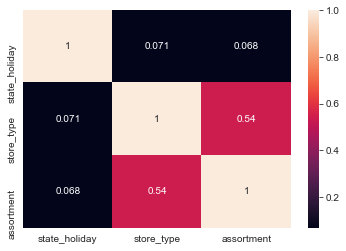

In [164]:
sns.heatmap(d, annot = True)